In [1]:
import sys, os
import numpy as np

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.equilibrate import EquilibratePD, EquilibratePDGrid, PDEquilibrateGridDiagnostics
from tcg_slb.base import *

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/numdifftools/multicomplex.py:35: DeprecationWarning: `finfo.machar` is deprecated (NumPy 1.22)
  _TINY = np.finfo(float).machar.tiny


In [2]:
from thermoengine.equilibrate import PhaseLibrary
import thermoengine as thermo

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Setup Equilibrate

In [3]:
db = thermo.model.Database(database='Stixrude')
all_phases = db.get_all_phases()
phase_library = PhaseLibrary(all_phases)

In [4]:
eq = EquilibratePD(phase_library)

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Temperature, pressure, composition

In [5]:
# initial temperature, pressure and phase volume fraction
Ti = 1673.                # Kelvin
pi = GPa2Bar(30.)         # bars
comp = thermo.OxideMolComp(SiO2=1, MgO=1, FeO=1)

### Solve the minimum Gibbs energy

In [6]:
eq.solve(Ti,pi,comp)

In [7]:
eq.final_rho(), eq.final_phases(), eq.assemblage.sample_endmem_comps

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


(48.74349716207368,
 (['Ferropericlase', 'Perovskite', 'Stishovite'], ['Fp', 'PrvS', 'Sti']),
 array([array([1.]), array([0.4, 0.6]), array([0.85, 0.15, 0.  ])],
       dtype=object))

## Solve for a grid

In [8]:
reload = False

import pickle

filename = os.path.join('output', 'equilibrate_te_mgfesio4_lowp.pickle')

if reload:
    pfile = open(filename, 'rb')
    equilgrid = pickle.load(pfile)
    pfile.close()
else:
    p_n = 60
    p_min = 0.0 + 0.5*30/p_n
    p_max = 30.0 - 0.5*30/p_n
    p_range = np.linspace(p_min, p_max, p_n)
    x_n = 50
    x_min = 0.5/x_n
    x_max = 1. - 0.5/x_n
    x_range = np.linspace(x_min, x_max, x_n)
    x0 = {'SiO2':1, 'MgO':2}
    x1 = {'SiO2':1, 'FeO':2}
    equilgrid = EquilibratePDGrid()
    equilgrid.solve(phase_library, ['X', 'p'], x_range, p_range, **{'T':Ti, 'X0':x0, 'X1':x1})

In [9]:
save = True

if not reload and save:
        pfile = open(filename, 'wb')
        pickle.dump(equilgrid, pfile)
        pfile.close()

In [10]:
import matplotlib.pyplot as plt

def decorate(pdrgd):
    def new_setup_axes(self,axi):
        img = plt.imread("figures/slb_figure10a.png")
        ip = axi.imshow(img)
        axi.axis('off')
        ax = axi.inset_axes([0.002,0.004,0.995,0.996])
        ax.patch.set_alpha(0.0)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 30.0])
        ax.set_ylabel("Pressure (GPa)")
        ax.set_xlabel("Initial $X_{Mg_2SiO_4}$")
        ax.invert_xaxis()
        return ax
    
    #replace the display with newdisplay
    pdrgd.setup_axes = new_setup_axes
    
    #return the modified student 
    return pdrgd

equildiag = decorate(PDEquilibrateGridDiagnostics)(phase_library,equilgrid)

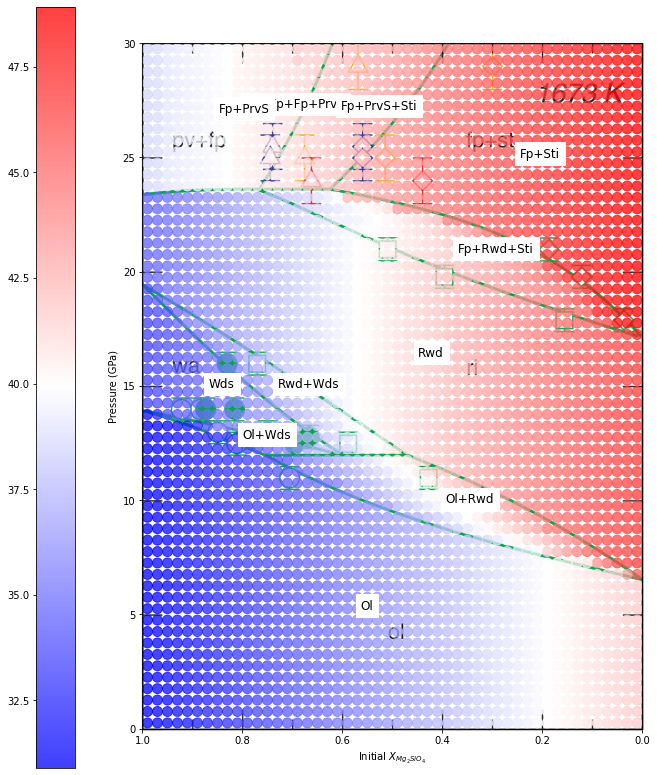

In [11]:
equildiag.plot_rho()

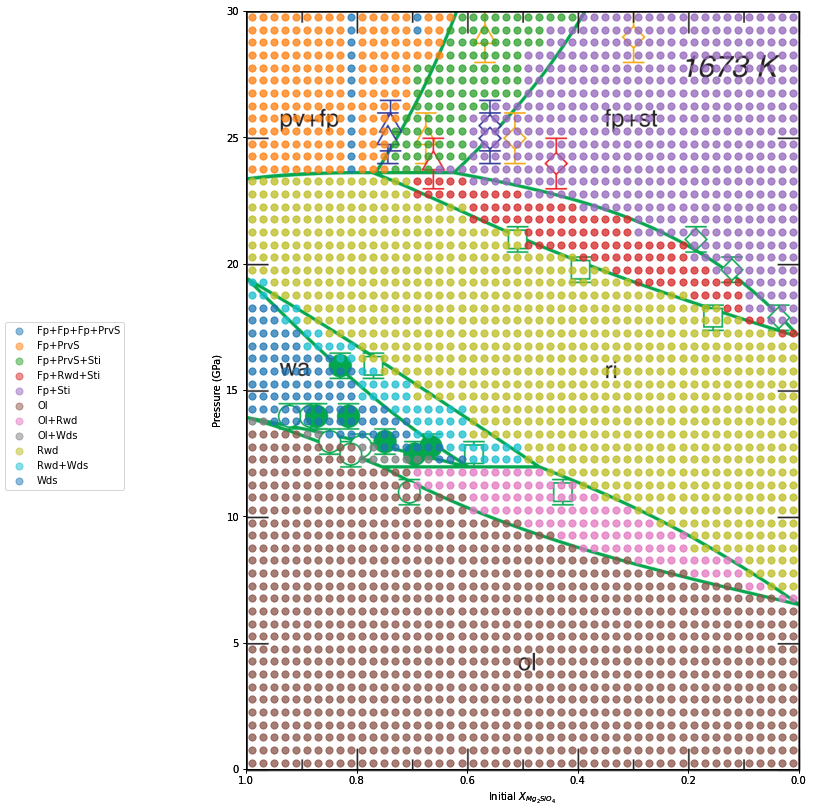

In [12]:
#%matplotlib widget
equildiag.plot_phases()

In [13]:
i=51; j=40
equilgrid.emcompgrid[i][j], equilgrid.phnamegrid[i][j], equilgrid.amountgrid[i][j], equilgrid.pgrid[i][j], equilgrid.Tgrid[i][j], equilgrid.cgrid[i][j]

(array([array([0.7, 0.3]), array([0.7, 0.3]), array([0.7, 0.3]),
        array([0.92, 0.08, 0.  ])], dtype=object),
 array(['Fp', 'Fp', 'Fp', 'PrvS'], dtype='<U4'),
 array([0.14285714, 0.14285714, 0.28571429, 0.71428571]),
 25.75,
 1673.0,
 {'SiO2': 1.0,
  'TiO2': 0.0,
  'Al2O3': 0.0,
  'Fe2O3': 0.0,
  'Cr2O3': 0.0,
  'FeO': 0.3799999999999999,
  'MnO': 0.0,
  'MgO': 1.62,
  'NiO': 0.0,
  'CoO': 0.0,
  'CaO': 0.0,
  'Na2O': 0.0,
  'K2O': 0.0,
  'P2O5': 0.0,
  'H2O': 0.0,
  'CO2': 0.0})

In [14]:
eq5140 = EquilibratePD(phase_library)
eq5140.solve(1673.,GPa2Bar(25.75),thermo.OxideMolComp(SiO2=1.0, FeO=0.38, MgO=1.62))

In [15]:
print(eq5140.system.summary)

T = 1673.00 K, P =  25.8 GPa
Ferropericlase   amt:   0.142857 mol
 | ----------- endmember mol frac ------------ |
 |      Periclase [MgO]             0.7000 mol |
 |       Wuestite [FeO]             0.3000 mol |
Ferropericlase   amt:   0.142857 mol
 | ----------- endmember mol frac ------------ |
 |      Periclase [MgO]             0.7000 mol |
 |       Wuestite [FeO]             0.3000 mol |
Ferropericlase   amt:   0.285714 mol
 | ----------- endmember mol frac ------------ |
 |      Periclase [MgO]             0.7000 mol |
 |       Wuestite [FeO]             0.3000 mol |
Perovskite       amt:   0.714286 mol
 | ----------- endmember mol frac ------------ |
 |   MgPerovskite [MgSiO3]          0.9200 mol |
 |   FePerovskite [FeSiO3]          0.0800 mol |
 |   AlPerovskite [Al2O3]           0.0000 mol |
... Olivine          affn:        inf J
 | ----------- endmember mol frac ------------ |
 |     Forsterite [Mg2SiO4]         1.0000 mol |
 |       Fayalite [Fe2SiO4]         0.0000 mol |

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
i=52; j=40
equilgrid.emcompgrid[i][j], equilgrid.phnamegrid[i][j], equilgrid.amountgrid[i][j], equilgrid.pgrid[i][j], equilgrid.Tgrid[i][j]

(array([array([0.7, 0.3]), array([0.92, 0.08, 0.  ])], dtype=object),
 array(['Fp', 'PrvS'], dtype='<U4'),
 array([0.28571428, 0.71428571]),
 26.25,
 1673.0)

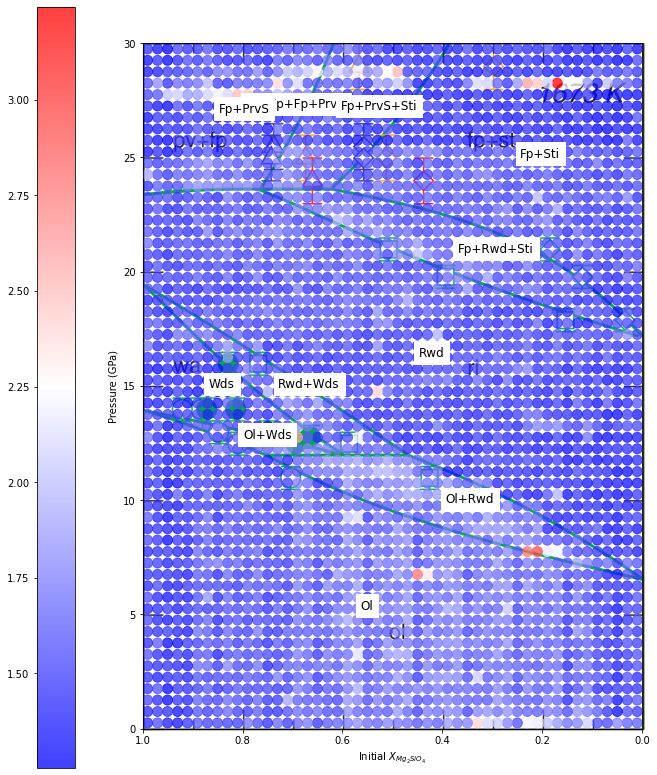

In [17]:
%matplotlib inline
equildiag.plot_stime()